<a href="https://colab.research.google.com/github/Amaliaaap/Machine-Learning/blob/main/Memprediksi%20Harga%20Penutupan%20Saham%20PT%20Indofood%20Sukses%20Makmur%20Tbk%20pada%20Tahun%202010-2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Memprediksi Harga Penutupan Saham PT Indofood Sukses Makmur Tbk pada Tahun 2010-2024**

## **Persiapan Data**

1. Import library

In [ ]:
# Import libraries
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from IPython.display import display

# Set plot style
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

2. Masukkan dataset

In [ ]:
df = pd.read_csv("Data Historis INDF.csv")
df

,Tanggal,Harga Saham
0,02-01-2013,5800
1,03-01-2013,5850
2,04-01-2013,5950
3,07-01-2013,5850
4,08-01-2013,6000
...,...,...
2888,22-11-2024,7475
2889,25-11-2024,7600
2890,26-11-2024,7650
2891,28-11-2024,7650


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Tanggal      2893 non-null   object
 1   Harga Saham  2893 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.3+ KB


## **EDA (Exploratory Data Analysis)**

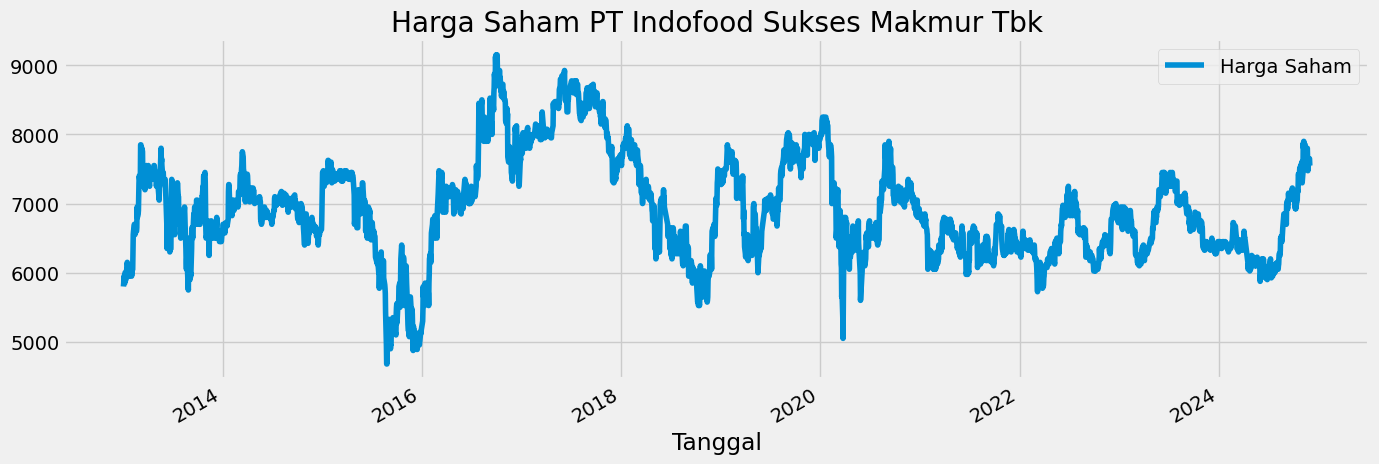

In [ ]:
df1 = df
df1 = df1.set_index('Tanggal')
df1.index = pd.to_datetime(df1.index, dayfirst=True)
df1.plot(figsize=(15,5),
        color=color_pal[0],
        title='Harga Saham PT Indofood Sukses Makmur Tbk')
plt.show()

## **Data Preprocessing**

1. Membuat fitur Lag dari dataframe

Fitur lag melibatkan penyertaan nilai lampau dari variabel target sebagai prediktor. Fungsi create_lag_features dalam kode yang diberikan menghasilkan fitur lag hingga sejumlah langkah waktu tertentu (lag_steps). Teknik ini memungkinkan model untuk menangkap ketergantungan temporal dan tren historis dalam data deret waktu.

In [ ]:
def create_lag_features(data, lag_steps=1, column_name='Harga Saham'):
    df = data.copy()
    for i in range(1, lag_steps + 1):
        df[f'Lag_{i}'] = df[column_name].shift(i)
    return df

lag_steps = 3
df = create_lag_features(df, lag_steps=lag_steps, column_name='Harga Saham')
df

,Tanggal,Harga Saham,Lag_1,Lag_2,Lag_3
0,02-01-2013,5800,NaN,NaN,NaN
1,03-01-2013,5850,5800.0,NaN,NaN
2,04-01-2013,5950,5850.0,5800.0,NaN
3,07-01-2013,5850,5950.0,5850.0,5800.0
4,08-01-2013,6000,5850.0,5950.0,5850.0
...,...,...,...,...,...
2888,22-11-2024,7475,7625.0,7800.0,7800.0
2889,25-11-2024,7600,7475.0,7625.0,7800.0
2890,26-11-2024,7650,7600.0,7475.0,7625.0
2891,28-11-2024,7650,7650.0,7600.0,7475.0


2. Membuat fitur *Rolling Mean* dari dataframe

Rata-rata bergulir adalah teknik yang memperhalus data deret waktu dengan menghitung rata-rata selama jendela pengamatan tertentu. Fungsi create_rolling_mean membuat fitur baru, 'rolling_mean,' dengan menghitung rata-rata variabel target selama ukuran jendela yang ditentukan pengguna. Ini membantu untuk menyoroti tren dan pola dengan mengurangi gangguan dan fluktuasi dalam data.

In [ ]:
def create_rolling_mean_features(data, window=3, column_name='Harga Saham'):
    df = data.copy()

    # Hitung rolling mean
    rolling_mean = df[column_name].rolling(window=window).mean()

    # Simpan rolling mean di satu baris setelahnya
    df[f'Rolling_Mean_{window}'] = rolling_mean.shift(+1)  # Menggeser ke atas

    return df

# Daftar langkah jendela
windows_steps = [5, 10, 30]
for window in windows_steps:
    df = create_rolling_mean_features(df, window=window, column_name='Harga Saham')

# Tampilkan DataFrame df
df.head(11)

,Tanggal,Harga Saham,Lag_1,Lag_2,Lag_3,Rolling_Mean_5,Rolling_Mean_10,Rolling_Mean_30
0,02-01-2013,5800,NaN,NaN,NaN,NaN,NaN,NaN
1,03-01-2013,5850,5800.0,NaN,NaN,NaN,NaN,NaN
2,04-01-2013,5950,5850.0,5800.0,NaN,NaN,NaN,NaN
3,07-01-2013,5850,5950.0,5850.0,5800.0,NaN,NaN,NaN
4,08-01-2013,6000,5850.0,5950.0,5850.0,NaN,NaN,NaN
5,09-01-2013,6000,6000.0,5850.0,5950.0,5890.0,NaN,NaN
6,10-01-2013,5900,6000.0,6000.0,5850.0,5930.0,NaN,NaN
7,11-01-2013,5900,5900.0,6000.0,6000.0,5940.0,NaN,NaN
8,14-01-2013,6050,5900.0,5900.0,6000.0,5930.0,NaN,NaN
9,15-01-2013,6050,6050.0,5900.0,5900.0,5970.0,NaN,NaN


3. Menghapus *missing value*

In [ ]:
# Mengecek missing value
df.isnull().sum()

,0
Tanggal,0
Harga Saham,0
Lag_1,1
Lag_2,2
Lag_3,3
Rolling_Mean_5,5
Rolling_Mean_10,10
Rolling_Mean_30,30


In [ ]:
# Menghapus missing value
df.dropna(inplace=True)
df

,Tanggal,Harga Saham,Lag_1,Lag_2,Lag_3,Rolling_Mean_5,Rolling_Mean_10,Rolling_Mean_30
30,14-02-2013,6600,6550.0,6700.0,6700.0,6620.0,6355.0,6111.666667
31,15-02-2013,6700,6600.0,6550.0,6700.0,6630.0,6410.0,6138.333333
32,18-02-2013,6600,6700.0,6600.0,6550.0,6650.0,6485.0,6166.666667
33,19-02-2013,6600,6600.0,6700.0,6600.0,6630.0,6540.0,6188.333333
34,20-02-2013,6650,6600.0,6600.0,6700.0,6610.0,6595.0,6213.333333
...,...,...,...,...,...,...,...,...
2888,22-11-2024,7475,7625.0,7800.0,7800.0,7735.0,7745.0,7544.166667
2889,25-11-2024,7600,7475.0,7625.0,7800.0,7685.0,7722.5,7560.000000
2890,26-11-2024,7650,7600.0,7475.0,7625.0,7660.0,7702.5,7578.333333
2891,28-11-2024,7650,7650.0,7600.0,7475.0,7630.0,7682.5,7593.333333


4. Mengubah dataframe menjadi data *time series*

In [ ]:
df = df.set_index('Tanggal')
df.index = pd.to_datetime(df.index, dayfirst=True)
df

,Harga Saham,Lag_1,Lag_2,Lag_3,Rolling_Mean_5,Rolling_Mean_10,Rolling_Mean_30
Tanggal,,,,,,,
2013-02-14,6600,6550.0,6700.0,6700.0,6620.0,6355.0,6111.666667
2013-02-15,6700,6600.0,6550.0,6700.0,6630.0,6410.0,6138.333333
2013-02-18,6600,6700.0,6600.0,6550.0,6650.0,6485.0,6166.666667
2013-02-19,6600,6600.0,6700.0,6600.0,6630.0,6540.0,6188.333333
2013-02-20,6650,6600.0,6600.0,6700.0,6610.0,6595.0,6213.333333
...,...,...,...,...,...,...,...
2024-11-22,7475,7625.0,7800.0,7800.0,7735.0,7745.0,7544.166667
2024-11-25,7600,7475.0,7625.0,7800.0,7685.0,7722.5,7560.000000
2024-11-26,7650,7600.0,7475.0,7625.0,7660.0,7702.5,7578.333333


5. Mengubah data menjadi hanya memiliki 2 angka desimal

In [ ]:
df = df.round(2)
df

,Harga Saham,Lag_1,Lag_2,Lag_3,Rolling_Mean_5,Rolling_Mean_10,Rolling_Mean_30
Tanggal,,,,,,,
2013-02-14,6600,6550.0,6700.0,6700.0,6620.0,6355.0,6111.67
2013-02-15,6700,6600.0,6550.0,6700.0,6630.0,6410.0,6138.33
2013-02-18,6600,6700.0,6600.0,6550.0,6650.0,6485.0,6166.67
2013-02-19,6600,6600.0,6700.0,6600.0,6630.0,6540.0,6188.33
2013-02-20,6650,6600.0,6600.0,6700.0,6610.0,6595.0,6213.33
...,...,...,...,...,...,...,...
2024-11-22,7475,7625.0,7800.0,7800.0,7735.0,7745.0,7544.17
2024-11-25,7600,7475.0,7625.0,7800.0,7685.0,7722.5,7560.00
2024-11-26,7650,7600.0,7475.0,7625.0,7660.0,7702.5,7578.33


6. Ekstraksi komponen tanggal

In [ ]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)
df

,Harga Saham,Lag_1,Lag_2,Lag_3,Rolling_Mean_5,Rolling_Mean_10,Rolling_Mean_30,quarter,month,year,dayofyear,dayofmonth,weekofyear
Tanggal,,,,,,,,,,,,,
2013-02-14,6600,6550.0,6700.0,6700.0,6620.0,6355.0,6111.67,1,2,2013,45,14,7
2013-02-15,6700,6600.0,6550.0,6700.0,6630.0,6410.0,6138.33,1,2,2013,46,15,7
2013-02-18,6600,6700.0,6600.0,6550.0,6650.0,6485.0,6166.67,1,2,2013,49,18,8
2013-02-19,6600,6600.0,6700.0,6600.0,6630.0,6540.0,6188.33,1,2,2013,50,19,8
2013-02-20,6650,6600.0,6600.0,6700.0,6610.0,6595.0,6213.33,1,2,2013,51,20,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22,7475,7625.0,7800.0,7800.0,7735.0,7745.0,7544.17,4,11,2024,327,22,47
2024-11-25,7600,7475.0,7625.0,7800.0,7685.0,7722.5,7560.00,4,11,2024,330,25,48
2024-11-26,7650,7600.0,7475.0,7625.0,7660.0,7702.5,7578.33,4,11,2024,331,26,48


## **Membuat Model**

### **Membagi Data**

In [ ]:
X = df[['Lag_1',	'Lag_2',	'Lag_3',	'Rolling_Mean_5',	'Rolling_Mean_10',	'Rolling_Mean_30', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y = df['Harga Saham']

# Menghitung indeks untuk data latih dan uji
train_size = int(len(X) * 0.8)  # 80% untuk data latih
test_size = len(X) - train_size  # 20% untuk data uji

# Membagi data
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

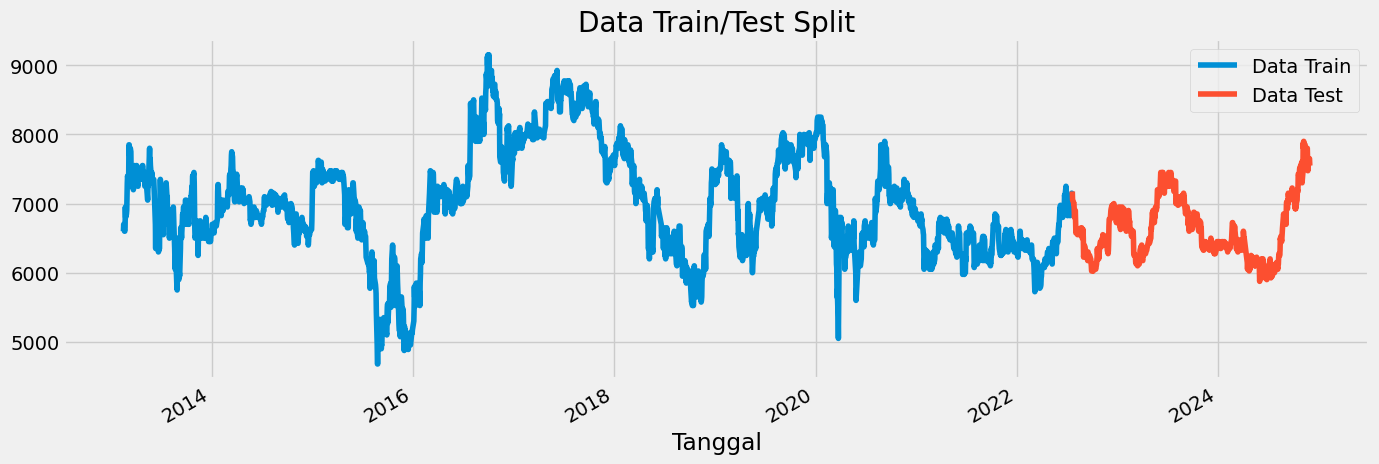

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
y_train.plot(ax=ax, label='Data Train', title="Data Train/Test Split")
y_test.plot(ax=ax, label='Data Test')
ax.legend(['Data Train', 'Data Test'])
plt.show()

In [ ]:
X_train

,Lag_1,Lag_2,Lag_3,Rolling_Mean_5,Rolling_Mean_10,Rolling_Mean_30,quarter,month,year,dayofyear,dayofmonth,weekofyear
Tanggal,,,,,,,,,,,,
2013-02-14,6550.0,6700.0,6700.0,6620.0,6355.0,6111.67,1,2,2013,45,14,7
2013-02-15,6600.0,6550.0,6700.0,6630.0,6410.0,6138.33,1,2,2013,46,15,7
2013-02-18,6700.0,6600.0,6550.0,6650.0,6485.0,6166.67,1,2,2013,49,18,8
2013-02-19,6600.0,6700.0,6600.0,6630.0,6540.0,6188.33,1,2,2013,50,19,8
2013-02-20,6600.0,6600.0,6700.0,6610.0,6595.0,6213.33,1,2,2013,51,20,8
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-14,6825.0,7050.0,7025.0,6965.0,6965.0,6940.83,3,7,2022,195,14,28
2022-07-15,6925.0,6825.0,7050.0,6970.0,6952.5,6948.33,3,7,2022,196,15,28
2022-07-18,6900.0,6925.0,6825.0,6945.0,6940.0,6955.83,3,7,2022,199,18,29


In [ ]:
y_train

,Harga Saham
Tanggal,
2013-02-14,6600
2013-02-15,6700
2013-02-18,6600
2013-02-19,6600
2013-02-20,6650
...,...
2022-07-14,6925
2022-07-15,6900
2022-07-18,7050


In [ ]:
X_test

,Lag_1,Lag_2,Lag_3,Rolling_Mean_5,Rolling_Mean_10,Rolling_Mean_30,quarter,month,year,dayofyear,dayofmonth,weekofyear
Tanggal,,,,,,,,,,,,
2022-07-21,7100.0,7150.0,7050.0,7025.0,6995.0,6971.67,3,7,2022,202,21,29
2022-07-22,7175.0,7100.0,7150.0,7075.0,7022.5,6981.67,3,7,2022,203,22,29
2022-07-25,7050.0,7175.0,7100.0,7105.0,7025.0,6987.50,3,7,2022,206,25,30
2022-07-26,7025.0,7050.0,7175.0,7100.0,7025.0,6994.17,3,7,2022,207,26,30
2022-07-27,7000.0,7025.0,7050.0,7070.0,7020.0,6998.33,3,7,2022,208,27,30
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22,7625.0,7800.0,7800.0,7735.0,7745.0,7544.17,4,11,2024,327,22,47
2024-11-25,7475.0,7625.0,7800.0,7685.0,7722.5,7560.00,4,11,2024,330,25,48
2024-11-26,7600.0,7475.0,7625.0,7660.0,7702.5,7578.33,4,11,2024,331,26,48


In [ ]:
y_test

,Harga Saham
Tanggal,
2022-07-21,7175
2022-07-22,7050
2022-07-25,7025
2022-07-26,7000
2022-07-27,7000
...,...
2024-11-22,7475
2024-11-25,7600
2024-11-26,7650


### **Model XGBoost**

In [ ]:
# Inisialisasi model XGBoost
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=5)

# Melatih model
xgb_model.fit(X_train, y_train)

# Memprediksi dengan model
y_pred_xgb = xgb_model.predict(X_test)

# Menghitung metrik evaluasi
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)

# Menampilkan hasil evaluasi
print("Hasil Evaluasi XGBoost:")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb}%")
print(f"R-squared (R²): {r2_xgb}")

Hasil Evaluasi XGBoost:
Mean Absolute Error (MAE): 66.9279269606239
Mean Squared Error (MSE): 7848.454845377704
Mean Absolute Percentage Error (MAPE): 1.0042858136963502%
R-squared (R²): 0.9587169885635376


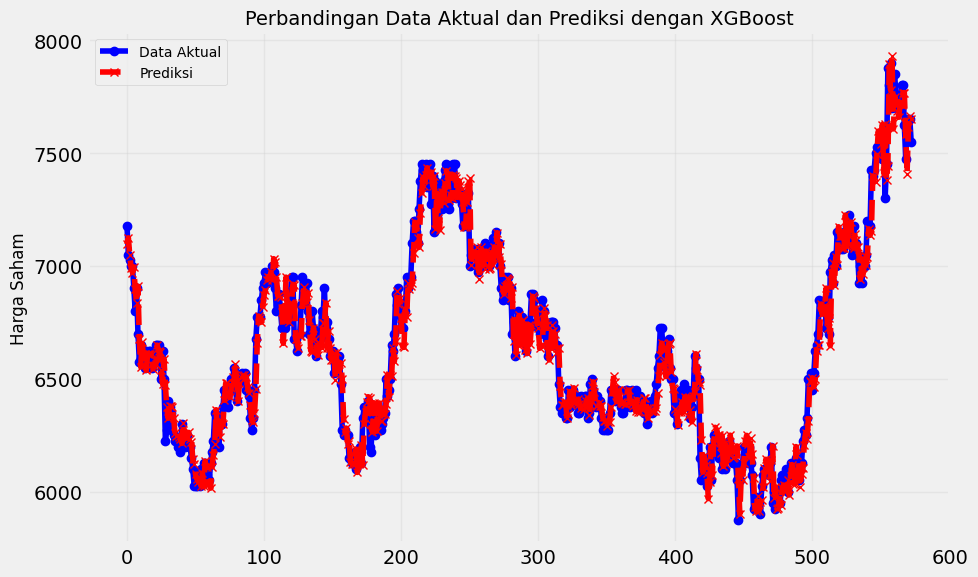

In [ ]:
# Mengatur ukuran figure
plt.figure(figsize=(10, 6))

# Plot data aktual
plt.plot(
    range(len(y_test)),
    y_test,
    label="Data Aktual",
    color="blue",
    marker='o',
    linestyle='-'
)

# Plot prediksi
plt.plot(
    range(len(y_pred_xgb)),
    y_pred_xgb,
    label="Prediksi",
    color="red",
    marker='x',
    linestyle='--'
)

# Menambahkan judul dan label
plt.title("Perbandingan Data Aktual dan Prediksi dengan XGBoost", fontsize=14)
plt.ylabel("Harga Saham", fontsize=12)

# Menampilkan legenda dan grid
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Mengatur layout dan menampilkan plot
plt.tight_layout()
plt.show()

Feature Importances (XGBoost):


,Feature,Importance
0,Lag_1,0.922734
3,Rolling_Mean_5,0.026433
1,Lag_2,0.012815
4,Rolling_Mean_10,0.005892
6,quarter,0.005248
8,year,0.004923
5,Rolling_Mean_30,0.004680
2,Lag_3,0.004454
9,dayofyear,0.003903
11,weekofyear,0.003782


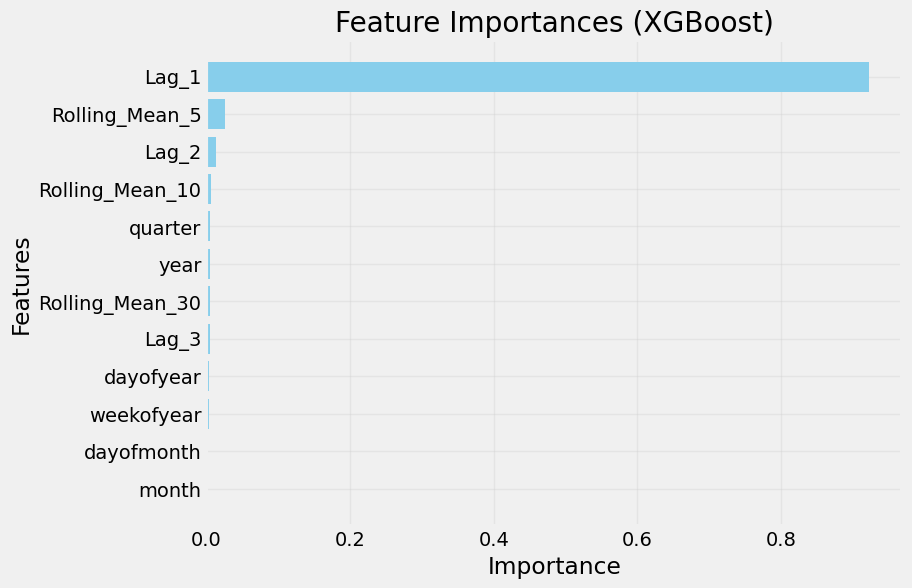

In [ ]:
# Mengambil pentingnya fitur dari model XGBoost
importances = xgb_model.feature_importances_

# Nama-nama fitur
feature_names = [
    'Lag_1', 'Lag_2', 'Lag_3',
    'Rolling_Mean_5', 'Rolling_Mean_10', 'Rolling_Mean_30',
    'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear'
]

# Membuat DataFrame untuk pentingnya fitur
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Menampilkan pentingnya fitur
print("Feature Importances (XGBoost):")
display(importances_df)

# Visualisasi pentingnya fitur
plt.figure(figsize=(8, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(alpha=0.3)
plt.show()

### **Model LSTM**

In [ ]:
# Fungsi untuk mengatur seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Mengatur seed
set_seed(42)

# Inisialisasi scaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Melakukan scaling pada data
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Fungsi untuk membuat dataset
def create_dataset(X, y, time_step=1):
    X_data, y_data = [], []
    for i in range(len(X) - time_step):
        X_data.append(X[i:(i + time_step)])
        y_data.append(y[i + time_step])
    return np.array(X_data), np.array(y_data)

# Membuat dataset dengan time step
time_step = 60
X_lstm, y_lstm = create_dataset(X_scaled, y_scaled, time_step)

# Membagi data menjadi train dan test
X_train_lstm = X_lstm[:train_size]
X_test_lstm = X_lstm[train_size:]
y_train_lstm = y_lstm[:train_size]
y_test_lstm = y_lstm[train_size:]

# Membangun model LSTM
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

# Mengompilasi model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Mengatur early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50, batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop],
    verbose=1
)

# Memprediksi dengan model
y_pred_lstm = model.predict(X_test_lstm)

# Menghitung metrik evaluasi
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

# Menampilkan hasil evaluasi
print("\nHasil Evaluasi LSTM:")
print(f"Mean Absolute Error (MAE) : {mae_lstm}")
print(f"Mean Squared Error (MSE) : {mse_lstm}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape_lstm}%")
print(f"R-squared (R²) : {r2_lstm}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - loss: 0.0433 - val_loss: 0.0031
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 232ms/step - loss: 0.0059 - val_loss: 0.0024
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - loss: 0.0038 - val_loss: 0.0026
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step

Hasil Evaluasi LSTM:
Mean Absolute Error (MAE) : 0.03780902609685978
Mean Squared Error (MSE) : 0.0024027925383414465
Mean Absolute Percentage Error (MAPE) : 8.272829089746004%
R-squared (R²) : 0.7550148076572492


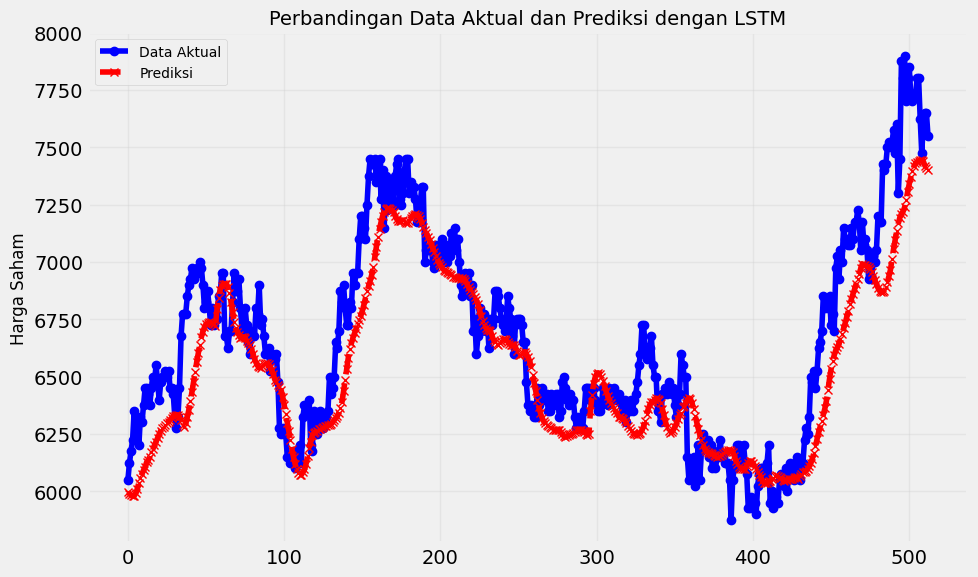

In [ ]:
# Mengembalikan data ke skala asli
y_test_lstm_original = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))
y_pred_lstm_original = scaler_y.inverse_transform(y_pred_lstm)

# Membuat figure untuk visualisasi
plt.figure(figsize=(10, 6))

# Plot data aktual
plt.plot(
    range(len(y_test_lstm_original)),
    y_test_lstm_original.flatten(),
    label="Data Aktual",
    color="blue",
    marker='o',
    linestyle='-'
)

# Plot prediksi
plt.plot(
    range(len(y_pred_lstm_original)),
    y_pred_lstm_original.flatten(),
    label="Prediksi",
    color="red",
    marker='x',
    linestyle='--'
)

# Menambahkan judul dan label
plt.title("Perbandingan Data Aktual dan Prediksi dengan LSTM", fontsize=14)
plt.ylabel("Harga Saham", fontsize=12)

# Menampilkan legenda dan grid
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Mengatur layout dan menampilkan plot
plt.tight_layout()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

,Feature,Importance
0,Lag_1,0.001540
1,Lag_2,0.001506
3,Rolling_Mean_5,0.000724
4,Rolling_Mean_10,0.000514
11,weekofyear,0.000476
2,Lag_3,0.000400
6,quarter,0.000071
5,Rolling_Mean_30,0.000023
8,year,0.000005
9,dayofyear,0.000004


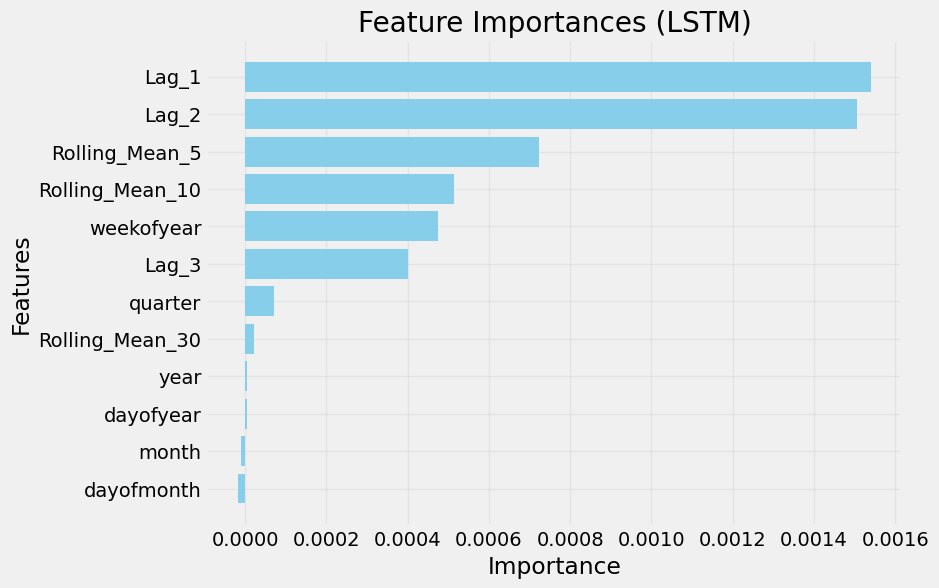

In [ ]:
def compute_permutation_importance(model, X, y, time_step, n_features, n_repeats=10, scoring='neg_mean_squared_error'):
    # Memprediksi nilai y dan menghitung error dasar
    y_pred = model.predict(X).flatten()
    baseline_error = mean_squared_error(y, y_pred)

    # Inisialisasi array untuk menyimpan pentingnya fitur
    importances = np.zeros((n_repeats, n_features))

    # Menghitung pentingnya fitur
    for feature_idx in range(n_features):
        for repeat in range(n_repeats):
            # Membuat salinan dari X dan mengacak fitur yang sedang dianalisis
            X_permuted = X.copy()
            X_permuted[:, :, feature_idx] = np.random.permutation(X_permuted[:, :, feature_idx])

            # Memprediksi dengan data yang telah diacak
            y_pred_permuted = model.predict(X_permuted).flatten()

            # Menghitung error untuk data yang telah diacak
            permuted_error = mean_squared_error(y, y_pred_permuted)

            # Menghitung pentingnya fitur
            importances[repeat, feature_idx] = permuted_error - baseline_error

    # Menghitung rata-rata pentingnya fitur
    importances_mean = importances.mean(axis=0)

    return importances_mean


# Menghitung pentingnya fitur
importances = compute_permutation_importance(
    model=model,
    X=X_test_lstm,
    y=y_test_lstm,
    time_step=time_step,
    n_features=X.shape[1],
    n_repeats=3
)

# Nama-nama fitur
feature_names = [
    'Lag_1',
    'Lag_2',
    'Lag_3',
    'Rolling_Mean_5',
    'Rolling_Mean_10',
    'Rolling_Mean_30',
    'quarter',
    'month',
    'year',
    'dayofyear',
    'dayofmonth',
    'weekofyear'
]

# Membuat DataFrame untuk pentingnya fitur
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Menampilkan pentingnya fitur
print("Feature Importances (LSTM):")
display(importances_df)

# Visualisasi pentingnya fitur
plt.figure(figsize=(8, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Feature Importances (LSTM)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(alpha=0.3)
plt.show()

### **Model Gradient Boosting**

In [ ]:
# Inisialisasi model Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Melatih model dengan data pelatihan
gb_model.fit(X_train, y_train)

# Memprediksi nilai dengan data uji
y_pred_gb = gb_model.predict(X_test)

# Mengubah hasil prediksi menjadi DataFrame
y_pred_gb_df = pd.DataFrame(y_pred_gb, index=y_test.index, columns=['Terakhir'])

# Menghitung metrik evaluasi
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100
r2_gb = r2_score(y_test, y_pred_gb)

# Menampilkan hasil evaluasi
print("Hasil Evaluasi Gradient Boosting:")
print(f"Mean Absolute Error (MAE): {mae_gb}")
print(f"Mean Squared Error (MSE): {mse_gb}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_gb}%")
print(f"R-squared (R²): {r2_gb}")

Hasil Evaluasi Gradient Boosting:
Mean Absolute Error (MAE): 68.27334259710105
Mean Squared Error (MSE): 8097.058756633193
Mean Absolute Percentage Error (MAPE): 1.024709629783344%
R-squared (R²): 0.9574093535959249


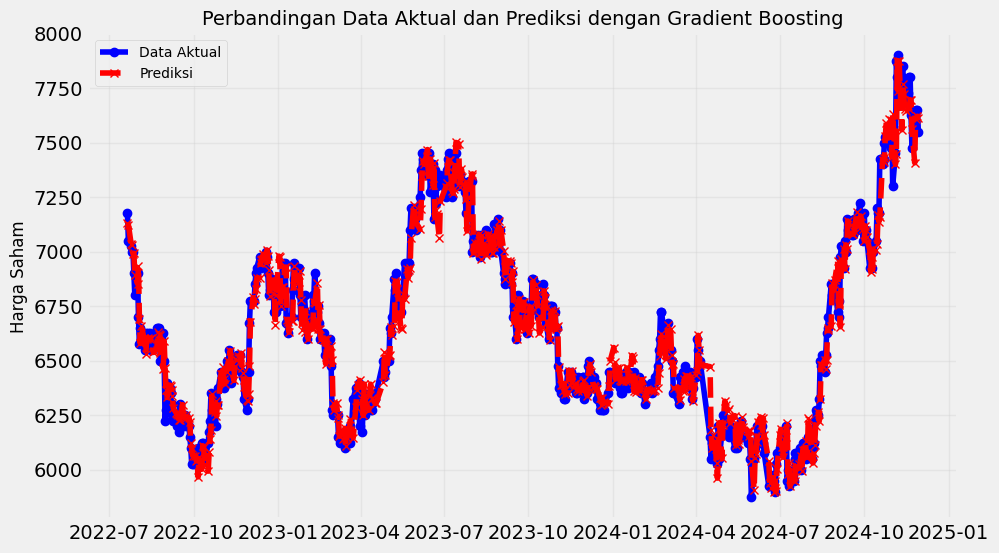

In [ ]:
# Mengatur ukuran figure untuk plot
plt.figure(figsize=(10, 6))

# Plot data aktual
plt.plot(
    y_test,
    label="Data Aktual",
    color="blue",
    marker='o',
    linestyle='-'
)

# Plot data prediksi
plt.plot(
    y_pred_gb_df,
    label="Prediksi",
    color="red",
    marker='x',
    linestyle='--'
)

# Menambahkan judul dan label
plt.title("Perbandingan Data Aktual dan Prediksi dengan Gradient Boosting", fontsize=14)
plt.ylabel("Harga Saham", fontsize=12)

# Menampilkan legenda
plt.legend(fontsize=10)

# Menambahkan grid untuk memperjelas plot
plt.grid(alpha=0.3)

# Menampilkan plot
plt.show()

Feature Importances (Gradient Boosting):


,Feature,Importance
0,Lag_1,0.972193
1,Lag_2,0.007345
3,Rolling_Mean_5,0.006362
4,Rolling_Mean_10,0.003947
5,Rolling_Mean_30,0.003603
9,dayofyear,0.002064
2,Lag_3,0.001914
10,dayofmonth,0.001010
8,year,0.000947
11,weekofyear,0.000415


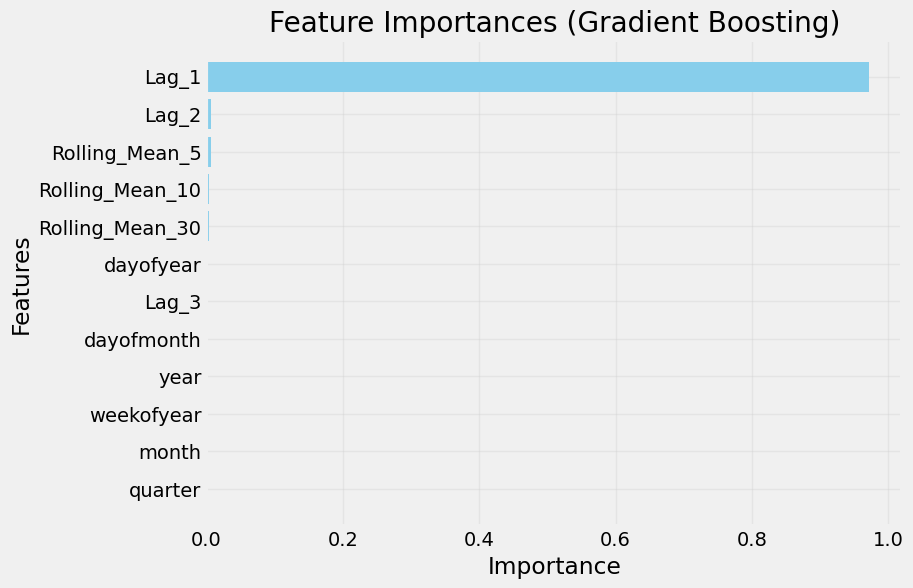

In [ ]:
# Mengambil nilai pentingnya fitur dari model Gradient Boosting
importances = gb_model.feature_importances_

# Daftar nama fitur
feature_names = [
    'Lag_1',
    'Lag_2',
    'Lag_3',
    'Rolling_Mean_5',
    'Rolling_Mean_10',
    'Rolling_Mean_30',
    'quarter',
    'month',
    'year',
    'dayofyear',
    'dayofmonth',
    'weekofyear'
]

# Membuat DataFrame untuk menyimpan nama fitur dan nilai pentingnya
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Menampilkan hasil pentingnya fitur
print("Feature Importances (Gradient Boosting):")
display(importances_df)

# Membuat plot horizontal untuk pentingnya fitur
plt.figure(figsize=(8, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Membalik sumbu y agar fitur terpenting di atas
plt.title("Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.grid(alpha=0.3)  # Menambahkan grid untuk memperjelas plot
plt.show()

## **Membandingkan Model**

In [ ]:
# Menyimpan hasil metrik evaluasi dalam dictionary
hasil_metrik_evaluasi = {
    "Model": ["XGBoost", "LSTM (Long Short-Term Memory)", "Gradient Boosting"],
    "MAE": [mae_xgb, mae_lstm, mae_gb],
    "MSE": [mse_xgb, mse_lstm, mse_gb],
    "MAPE": [mape_xgb, mape_lstm, mape_gb],
    "R²": [r2_xgb, r2_lstm, r2_gb]
}

# Mengubah dictionary menjadi DataFrame
hasil_metrik_evaluasi_hme = pd.DataFrame(hasil_metrik_evaluasi)

# Menampilkan hasil metrik evaluasi
print("Hasil dari Metrik Evaluasi:\n")
display(hasil_metrik_evaluasi_hme)

Hasil dari Metrik Evaluasi:



,Model,MAE,MSE,MAPE,R²
0,XGBoost,66.927927,7848.454845,1.004286,0.958717
1,LSTM (Long Short-Term Memory),0.037809,0.002403,8.272829,0.755015
2,Gradient Boosting,68.273343,8097.058757,1.024710,0.957409


Analisis Metrik:
* MAE: Model LSTM memiliki nilai MAE terendah (0.037809), menunjukkan bahwa prediksinya lebih akurat dalam hal kesalahan rata-rata absolut dibandingkan dengan XGBoost dan Gradient Boosting.
* MSE: LSTM juga memiliki nilai MSE terendah (0.002403), yang menunjukkan bahwa kesalahan kuadrat rata-rata lebih kecil, menandakan performa yang lebih baik dalam hal variabilitas kesalahan.
* MAPE: Untuk MAPE, XGBoost memiliki nilai terendah (1.004286), yang menunjukkan bahwa persentase kesalahan rata-rata lebih kecil dibandingkan dengan LSTM dan Gradient Boosting.
* R²: XGBoost memiliki nilai R² tertinggi (0.958717), yang menunjukkan bahwa model ini menjelaskan proporsi varians dalam data lebih baik daripada model lainnya.

Kesimpulan:
Berdasarkan analisis di atas, meskipun LSTM menunjukkan performa yang sangat baik dalam hal MAE dan MSE, XGBoost adalah model terbaik secara keseluruhan karena memiliki nilai R² tertinggi dan MAPE terendah, menunjukkan kombinasi akurasi dan kemampuan menjelaskan varians data yang lebih baik.
Oleh karena itu, model terbaik untuk memprediksi data berdasarkan evaluasi ini adalah XGBoost.